In [8]:
import datetime as dt

import numpy as np
import pandas as pd
import openmeteo_requests


def fetch_daily_precip_last_n_days(locations, n_days=774, timezone="auto", end_date=None):
    """
    Returns a long DataFrame with daily precipitation_sum (mm) for each location
    over the last n_days full days.

    - Uses Open-Meteo Historical Weather API: https://archive-api.open-meteo.com/v1/archive
    - Daily variable: precipitation_sum (units default mm)
    """
    openmeteo = openmeteo_requests.Client()

    if end_date is None:
        # "últimos n_days" como días COMPLETOS: termina en ayer
        end_date = dt.date.today() - dt.timedelta(days=1)

    start_date = end_date - dt.timedelta(days=n_days - 1)

    lats = [loc["coords"][0] for loc in locations]
    lons = [loc["coords"][1] for loc in locations]

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lats,
        "longitude": lons,
        "start_date": start_date.isoformat(),
        "end_date": end_date.isoformat(),
        "daily": ["precipitation_sum"],
        "timezone": timezone,  # requerido si pides daily
        # "precipitation_unit": "mm",  # opcional (default mm)
    }

    responses = openmeteo.weather_api(url, params=params)

    rows = []
    for loc, resp in zip(locations, responses):
        daily = resp.Daily()

        # Solo pedimos 1 variable diaria => índice 0
        precip_mm = daily.Variables(0).ValuesAsNumpy()

        # Tiempos vienen como epoch seconds; ajusta a "fecha local" con el offset
        t_utc = pd.to_datetime(
            np.array(range(daily.Time(), daily.TimeEnd(), daily.Interval())),
            unit="s",
            utc=True,
        )
        t_local = t_utc + pd.to_timedelta(resp.UtcOffsetSeconds(), unit="s")
        dates = pd.Series(t_local.date)

        if len(dates) != len(precip_mm):
            raise RuntimeError(
                f"Longitud inconsistente en {loc['name']}: "
                f"dates={len(dates)} vs precip={len(precip_mm)}"
            )

        rows.extend(
            {
                "date": d,
                "name": loc["name"],
                "lat": loc["coords"][0],
                "lon": loc["coords"][1],
                "precipitation_sum_mm": float(p),
                "premium": loc.get("premium"),
                "color": loc.get("color"),
            }
            for d, p in zip(dates, precip_mm)
        )

    df = pd.DataFrame(rows).sort_values(["date", "name"]).reset_index(drop=True)
    return df





In [4]:
locations = [
    # Base: Contract Price (Premium = 0)
    {"name": "Chicago Switching District", "coords": [41.8781, -87.6298], "premium": 0.00, "color": "gray"},
    {"name": "Burns Harbor Switching District", "coords": [41.6141, -87.1311], "premium": 0.00, "color": "gray"},

    # Lockport-Seneca (+4.75 cents)
    {"name": "Lockport", "coords": [41.5892, -88.0583], "premium": 4.75, "color": "green"},
    {"name": "Seneca", "coords": [41.3106, -88.6080], "premium": 4.75, "color": "green"},

    # Ottawa-Chillicothe (+6.25 cents)
    {"name": "Ottawa", "coords": [41.3456, -88.8426], "premium": 6.25, "color": "blue"},
    {"name": "Chillicothe", "coords": [40.9223, -89.4862], "premium": 6.25, "color": "blue"},

    # Peoria-Pekin (+8.75 cents)
    {"name": "Peoria", "coords": [40.6936, -89.5890], "premium": 8.75, "color": "purple"},
    {"name": "Pekin", "coords": [40.5675, -89.6407], "premium": 8.75, "color": "purple"},

    # Havana-Grafton (+10.25 cents)
    {"name": "Havana", "coords": [40.3003, -90.0604], "premium": 10.25, "color": "orange"},
    {"name": "Grafton", "coords": [38.9701, -90.4283], "premium": 10.25, "color": "orange"},

    # St. Louis-East St. Louis and Alton (+16.25 cents)
    {"name": "St. Louis / East St. Louis", "coords": [38.6270, -90.1994], "premium": 16.25, "color": "red"},
    {"name": "Alton", "coords": [38.8906, -90.1843], "premium": 16.25, "color": "red"},
]


In [6]:
from datetime import date

inicio = date(2024, 1, 1)
hoy = date.today()  # usa la fecha de hoy del sistema

dias = (hoy - inicio).days
print(dias)

# Si quieres contar inicio y hoy incluidos:
print(dias + 1)


774
775


In [9]:
# --- uso ---
df = fetch_daily_precip_last_n_days(locations, n_days=774, timezone="auto")

# Formato "largo" (tidy)
print(df.head())

# Formato "ancho": filas=fecha, columnas=location
df_wide = df.pivot(index="date", columns="name", values="precipitation_sum_mm").sort_index()
print(df_wide.tail())

# Exportables
# df.to_csv("precip_daily_long.csv", index=False)
# df_wide.to_csv("precip_daily_wide.csv")

         date                             name      lat      lon  \
0  2024-01-01                            Alton  38.8906 -90.1843   
1  2024-01-01  Burns Harbor Switching District  41.6141 -87.1311   
2  2024-01-01       Chicago Switching District  41.8781 -87.6298   
3  2024-01-01                      Chillicothe  40.9223 -89.4862   
4  2024-01-01                          Grafton  38.9701 -90.4283   

   precipitation_sum_mm  premium   color  
0                   0.0    16.25     red  
1                   2.2     0.00    gray  
2                   0.3     0.00    gray  
3                   0.0     6.25    blue  
4                   0.0    10.25  orange  
name        Alton  Burns Harbor Switching District  \
date                                                 
2026-02-08    0.0                              0.8   
2026-02-09    0.0                              0.0   
2026-02-10    0.0                              0.0   
2026-02-11    0.0                              0.0   
2026-02-1

C:\Users\herie\AppData\Local\Temp\ipykernel_16872\1467852025.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(todos_los_tickers, start="2024-01-01")['Close']
[*********************100%***********************]  15 of 15 completed

4 Failed downloads:
['ZCH25.CBT', 'ZCZ25.CBT', 'ZCK25.CBT', 'ZCU25.CBT']: YFTzMissingError('possibly delisted; no timezone found')


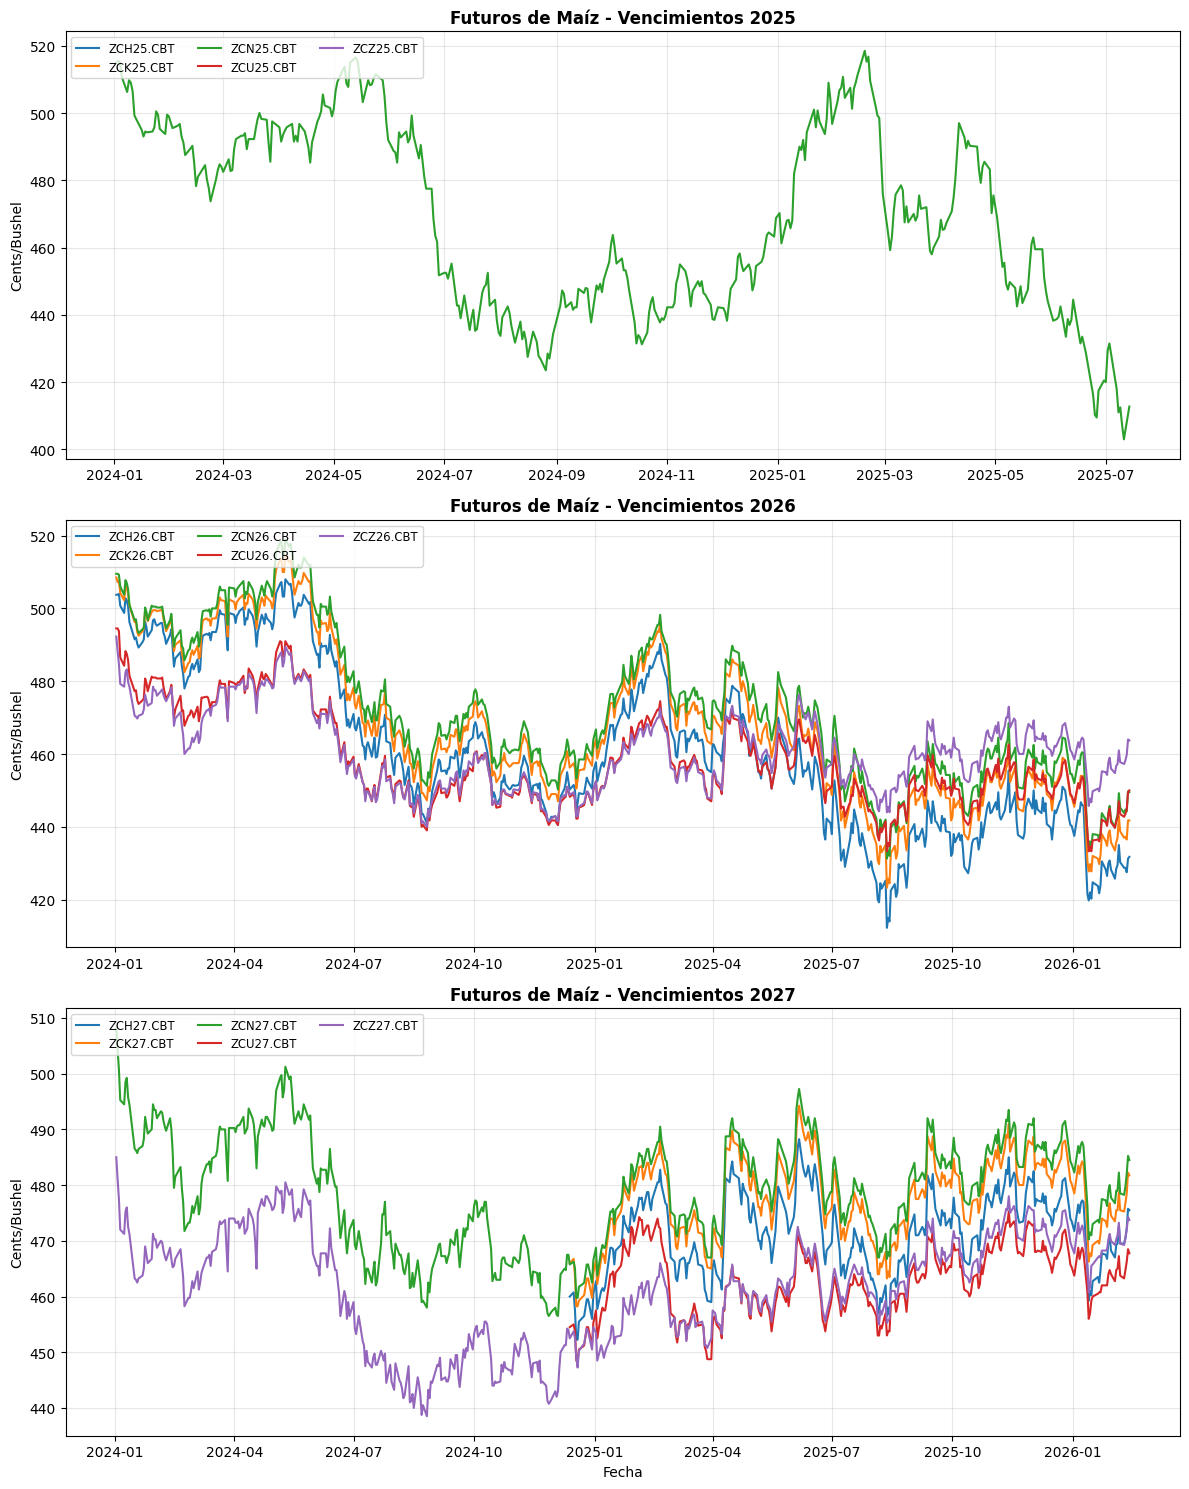

In [12]:
import yfinance as yf
import matplotlib.pyplot as plt

# 1. Definir los grupos de tickers por año
tickers_2025 = ["ZCH25.CBT", "ZCK25.CBT", "ZCN25.CBT", "ZCU25.CBT", "ZCZ25.CBT"]
tickers_2026 = ["ZCH26.CBT", "ZCK26.CBT", "ZCN26.CBT", "ZCU26.CBT", "ZCZ26.CBT"]
tickers_2027 = ["ZCH27.CBT", "ZCK27.CBT", "ZCN27.CBT", "ZCU27.CBT", "ZCZ27.CBT"]

todos_los_tickers = tickers_2025 + tickers_2026 + tickers_2027

# 2. Descargar datos (Precios de Cierre)
# Usamos una fecha que cubra el ciclo de vida de los contratos de 2025 también
data = yf.download(todos_los_tickers, start="2024-01-01")['Close']

# 3. Crear la figura con 3 subgráficos (uno para cada año)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=False)

# --- Gráfico 2025 ---
for t in tickers_2025:
    ax1.plot(data.index, data[t], label=t)
ax1.set_title('Futuros de Maíz - Vencimientos 2025', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cents/Bushel')
ax1.legend(loc='upper left', fontsize='small', ncol=3)
ax1.grid(True, alpha=0.3)

# --- Gráfico 2026 ---
for t in tickers_2026:
    ax2.plot(data.index, data[t], label=t)
ax2.set_title('Futuros de Maíz - Vencimientos 2026', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cents/Bushel')
ax2.legend(loc='upper left', fontsize='small', ncol=3)
ax2.grid(True, alpha=0.3)

# --- Gráfico 2027 ---
for t in tickers_2027:
    ax3.plot(data.index, data[t], label=t)
ax3.set_title('Futuros de Maíz - Vencimientos 2027', fontsize=12, fontweight='bold')
ax3.set_ylabel('Cents/Bushel')
ax3.set_xlabel('Fecha')
ax3.legend(loc='upper left', fontsize='small', ncol=3)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# pip install yfinance plotly openmeteo-requests pandas numpy

import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import openmeteo_requests


# -----------------------------
# 1) Precipitación diaria (Open-Meteo Historical)
# -----------------------------
def fetch_daily_precip_last_n_days(locations, n_days=774, timezone="auto", end_date=None):
    """
    Devuelve df largo: [date, name, precipitation_sum_mm, ...] para los últimos n_days días completos.
    Usa Historical Weather API (archive): https://archive-api.open-meteo.com/v1/archive
    """
    client = openmeteo_requests.Client()

    if end_date is None:
        end_date = dt.date.today() - dt.timedelta(days=1)  # ayer (día completo)

    start_date = end_date - dt.timedelta(days=n_days - 1)

    lats = [loc["coords"][0] for loc in locations]
    lons = [loc["coords"][1] for loc in locations]

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lats,
        "longitude": lons,
        "start_date": start_date.isoformat(),
        "end_date": end_date.isoformat(),
        "daily": ["precipitation_sum"],
        "timezone": timezone,
    }

    responses = client.weather_api(url, params=params)

    rows = []
    for loc, resp in zip(locations, responses):
        daily = resp.Daily()
        precip = daily.Variables(0).ValuesAsNumpy()

        # construir fechas (locales) desde epoch seconds + utc_offset
        t_utc = pd.to_datetime(
            np.arange(daily.Time(), daily.TimeEnd(), daily.Interval()),
            unit="s",
            utc=True,
        )
        t_local = t_utc + pd.to_timedelta(resp.UtcOffsetSeconds(), unit="s")
        dates = pd.Series(t_local.date)

        rows.extend(
            {
                "date": d,
                "name": loc["name"],
                "precipitation_sum_mm": float(p),
            }
            for d, p in zip(dates, precip)
        )

    return pd.DataFrame(rows).sort_values(["date", "name"]).reset_index(drop=True)


# -----------------------------
# 2) Descarga precios (yfinance)
# -----------------------------
tickers_2025 = ["ZCH25.CBT", "ZCK25.CBT", "ZCN25.CBT", "ZCU25.CBT", "ZCZ25.CBT"]
tickers_2026 = ["ZCH26.CBT", "ZCK26.CBT", "ZCN26.CBT", "ZCU26.CBT", "ZCZ26.CBT"]
tickers_2027 = ["ZCH27.CBT", "ZCK27.CBT", "ZCN27.CBT", "ZCU27.CBT", "ZCZ27.CBT"]
tickers = tickers_2025 + tickers_2026 + tickers_2027

prices_wide = yf.download(tickers, start="2024-01-01")["Close"]  # DataFrame: index=date, cols=tickers
prices_long = (
    prices_wide.reset_index()
    .rename(columns={"Date": "datetime"})
    .melt(id_vars="datetime", var_name="ticker", value_name="close")
    .dropna(subset=["close"])
)
prices_long["date"] = pd.to_datetime(prices_long["datetime"]).dt.date


# -----------------------------
# 3) Precipitación: define tu "índice de lluvia" por fecha
#    (a) media en todas las ubicaciones
#    (b) o una sola ubicación (ej. Chicago Switching District)
# -----------------------------
locations = [
    {"name": "Chicago Switching District", "coords": [41.8781, -87.6298]},
    {"name": "Burns Harbor Switching District", "coords": [41.6141, -87.1311]},
    {"name": "Lockport", "coords": [41.5892, -88.0583]},
    {"name": "Seneca", "coords": [41.3106, -88.6080]},
    {"name": "Ottawa", "coords": [41.3456, -88.8426]},
    {"name": "Chillicothe", "coords": [40.9223, -89.4862]},
    {"name": "Peoria", "coords": [40.6936, -89.5890]},
    {"name": "Pekin", "coords": [40.5675, -89.6407]},
    {"name": "Havana", "coords": [40.3003, -90.0604]},
    {"name": "Grafton", "coords": [38.9701, -90.4283]},
    {"name": "St. Louis / East St. Louis", "coords": [38.6270, -90.1994]},
    {"name": "Alton", "coords": [38.8906, -90.1843]},
]

df_precip = fetch_daily_precip_last_n_days(locations, n_days=774, timezone="auto")

# (a) lluvia = media espacial por fecha
rain_by_date = (
    df_precip.groupby("date", as_index=False)["precipitation_sum_mm"].mean()
    .rename(columns={"precipitation_sum_mm": "rain_mm"})
)

# (b) alternativa: una sola estación
# rain_by_date = (
#     df_precip[df_precip["name"] == "Chicago Switching District"][["date", "precipitation_sum_mm"]]
#     .rename(columns={"precipitation_sum_mm": "rain_mm"})
# )


# -----------------------------
# 4) Merge precios x lluvia (solo días con precio)
# -----------------------------
df = prices_long.merge(rain_by_date, on="date", how="inner")
df["time"] = pd.to_datetime(df["date"])  # eje x


# -----------------------------
# 5) Plotly 3D: x=time, y=rain, z=close
#    Un trace por ticker + dropdown para seleccionar
# -----------------------------
tickers_sorted = sorted(df["ticker"].unique())

fig = go.Figure()
for j, t in enumerate(tickers_sorted):
    dft = df[df["ticker"] == t].sort_values("time")
    fig.add_trace(
        go.Scatter3d(
            x=dft["time"],
            y=dft["rain_mm"],
            z=dft["close"],
            mode="lines+markers",
            name=t,
            visible=(j == 0),  # por defecto muestra solo el primero
            marker=dict(size=3),
            line=dict(width=3),
        )
    )

buttons = []
for j, t in enumerate(tickers_sorted):
    vis = [False] * len(tickers_sorted)
    vis[j] = True
    buttons.append(
        dict(
            label=t,
            method="update",
            args=[{"visible": vis}, {"title": f"3D: tiempo–lluvia–precio ({t})"}],
        )
    )

fig.update_layout(
    title=f"3D: tiempo–lluvia–precio ({tickers_sorted[0]})",
    scene=dict(
        xaxis_title="Tiempo",
        yaxis_title="Lluvia diaria (mm)",
        zaxis_title="Precio (Close)",
    ),
    updatemenus=[dict(buttons=buttons, direction="down", x=1.02, y=1.0, showactive=True)],
    margin=dict(l=0, r=220, t=50, b=0),
)

fig.show()


C:\Users\herie\AppData\Local\Temp\ipykernel_16872\3330402072.py:75: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_wide = yf.download(tickers, start="2024-01-01")["Close"]  # DataFrame: index=date, cols=tickers
[*********************100%***********************]  15 of 15 completed

4 Failed downloads:
['ZCH25.CBT', 'ZCZ25.CBT', 'ZCK25.CBT', 'ZCU25.CBT']: YFTzMissingError('possibly delisted; no timezone found')


In [15]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests

# -----------------------------
# 0) Preparación
# -----------------------------
def prepare_panel(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # normaliza date
    if "date" not in out.columns:
        if "time" in out.columns:
            out["date"] = pd.to_datetime(out["time"]).dt.date
        else:
            raise ValueError("Se requiere columna 'date' o 'time'.")

    out["date"] = pd.to_datetime(out["date"])
    out = out.sort_values(["ticker", "date"])

    # log-return por ticker
    out["log_close"] = np.log(out["close"].astype(float))
    out["ret"] = out.groupby("ticker")["log_close"].diff()

    # trimestre
    out["quarter"] = out["date"].dt.to_period("Q").astype(str)

    return out


# -----------------------------
# 1) Correlaciones (Pearson/Spearman)
# -----------------------------
def corr_tests(x: np.ndarray, y: np.ndarray):
    # retorna (coef, pvalue, n)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    n = len(x)
    if n < 3:
        return (np.nan, np.nan, n), (np.nan, np.nan, n)

    rp, pp = pearsonr(x, y)
    rs, ps = spearmanr(x, y)
    return (rp, pp, n), (rs, ps, n)


import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

def granger_min_pvalues(y: np.ndarray, x: np.ndarray, maxlag: int = 14, addconst: bool = True):
    """
    Prueba Granger x -> y sobre datos [y, x].
    Auto-ajusta L = min(maxlag, Lmax(n)).
    Devuelve p-values por lag + min p + best lag + lag usado.
    """
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)
    mask = np.isfinite(y) & np.isfinite(x)
    y = y[mask]
    x = x[mask]
    n = int(len(y))

    c = 1 if addconst else 0
    # Máximo lag permitido por statsmodels:
    # Lmax = floor((n - c)/3) - 1  (equivalente a su mensaje de error)
    Lmax = int(np.floor((n - c) / 3.0) - 1)

    if Lmax < 1:
        return {
            "n": n,
            "maxlag_used": 0,
            "p_by_lag": None,
            "min_p": np.nan,
            "best_lag": np.nan,
            "note": f"n={n} insuficiente para Granger (Lmax={Lmax})."
        }

    L = int(min(maxlag, Lmax))
    data = np.column_stack([y, x])

    res = grangercausalitytests(data, maxlag=L, addconst=addconst, verbose=False)

    p_by_lag = {int(lag): float(out[0]["ssr_ftest"][1]) for lag, out in res.items()}
    best_lag = min(p_by_lag, key=p_by_lag.get)

    return {
        "n": n,
        "maxlag_used": L,
        "p_by_lag": p_by_lag,
        "min_p": p_by_lag[best_lag],
        "best_lag": int(best_lag),
        "note": None
    }



# -----------------------------
# 3) Runner: global + trimestral por ticker
# -----------------------------
def run_all_tests(df_merged: pd.DataFrame, *, maxlag: int = 7, use_returns: bool = True):
    panel = prepare_panel(df_merged)

    y_col = "ret" if use_returns else "close"

    global_rows = []
    quarterly_rows = []

    for ticker, g in panel.groupby("ticker", sort=True):
        # GLOBAL: todo el historial disponible del ticker
        x = g["rain_mm"].to_numpy(dtype=float)
        y = g[y_col].to_numpy(dtype=float)

        (rp, pp, n1), (rs, ps, n2) = corr_tests(x, y)

        # Granger: lluvia -> precio (o return) y al revés
        gx_to_y = granger_min_pvalues(y=y, x=x, maxlag=maxlag)  # rain -> y
        gy_to_x = granger_min_pvalues(y=x, x=y, maxlag=maxlag)  # y -> rain

        global_rows.append({
            "ticker": ticker,
            "window": "GLOBAL",
            "n": int(np.isfinite(x).sum()),  # días con lluvia/price (antes de drop ret)
            "corr_pearson": rp, "p_pearson": pp,
            "corr_spearman": rs, "p_spearman": ps,
            "granger_rain_to_y_min_p": gx_to_y["min_p"],
            "granger_rain_to_y_best_lag": gx_to_y["best_lag"],
            "granger_y_to_rain_min_p": gy_to_x["min_p"],
            "granger_y_to_rain_best_lag": gy_to_x["best_lag"],
            "pvals_rain_to_y_by_lag": gx_to_y["p_by_lag"],
            "pvals_y_to_rain_by_lag": gy_to_x["p_by_lag"],
        })

        # TRIMESTRAL: por quarter (solo lo que exista para ese ticker)
        for q, h in g.groupby("quarter", sort=True):
            xq = h["rain_mm"].to_numpy(dtype=float)
            yq = h[y_col].to_numpy(dtype=float)

            (rp, pp, n1), (rs, ps, n2) = corr_tests(xq, yq)

            # dentro de run_all_tests(), donde ya haces:
            gx_to_y = granger_min_pvalues(y=yq, x=xq, maxlag=maxlag)
            gy_to_x = granger_min_pvalues(y=xq, x=yq, maxlag=maxlag)

            quarterly_rows.append({
                "ticker": ticker,
                "window": q,
                "n": int(np.isfinite(xq).sum()),
                "corr_pearson": rp, "p_pearson": pp,
                "corr_spearman": rs, "p_spearman": ps,
                "granger_rain_to_y_min_p": gx_to_y["min_p"],
                "granger_rain_to_y_best_lag": gx_to_y["best_lag"],
                "granger_y_to_rain_min_p": gy_to_x["min_p"],
                "granger_y_to_rain_best_lag": gy_to_x["best_lag"],
                "pvals_rain_to_y_by_lag": gx_to_y["p_by_lag"],
                "pvals_y_to_rain_by_lag": gy_to_x["p_by_lag"],
                "granger_rain_to_y_maxlag_used": gx_to_y["maxlag_used"],
                "granger_y_to_rain_maxlag_used": gy_to_x["maxlag_used"],
                "granger_rain_to_y_note": gx_to_y["note"],
                "granger_y_to_rain_note": gy_to_x["note"],
            })

    df_global = pd.DataFrame(global_rows).sort_values(["ticker"]).reset_index(drop=True)
    df_quarterly = pd.DataFrame(quarterly_rows).sort_values(["ticker", "window"]).reset_index(drop=True)

    return df_global, df_quarterly


# -----------------------------
# 4) Ejecuta e imprime TODO
# -----------------------------
# df es tu merge con columnas: date/ticker/close/rain_mm
# maxlag típico diario: 7, 14, 21
df_global, df_quarterly = run_all_tests(df, maxlag=14, use_returns=True)

pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 200)

print("\n===== RESULTADOS GLOBALES (por ticker) =====")
print(df_global)

print("\n===== RESULTADOS TRIMESTRALES (por ticker x quarter) =====")
print(df_quarterly)

# Opcional: exportar
# df_global.to_csv("tests_global.csv", index=False)
# df_quarterly.to_csv("tests_quarterly.csv", index=False)


c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

c:\Users\herie\miniconda3\envs\a\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

c:\U


===== RESULTADOS GLOBALES (por ticker) =====
       ticker  window    n  corr_pearson  p_pearson  corr_spearman  \
0   ZCH26.CBT  GLOBAL  532      0.014192   0.744212      -0.030781   
1   ZCH27.CBT  GLOBAL  292      0.060532   0.303432      -0.065424   
2   ZCK26.CBT  GLOBAL  532      0.021691   0.617974      -0.030291   
3   ZCK27.CBT  GLOBAL  292      0.065378   0.266286      -0.064349   
4   ZCN25.CBT  GLOBAL  384     -0.010485   0.837945      -0.047272   
5   ZCN26.CBT  GLOBAL  532      0.017192   0.692652      -0.040499   
6   ZCN27.CBT  GLOBAL  532      0.030937   0.476844      -0.052872   
7   ZCU26.CBT  GLOBAL  532      0.008301   0.848658      -0.072645   
8   ZCU27.CBT  GLOBAL  292      0.053928   0.359330      -0.059839   
9   ZCZ26.CBT  GLOBAL  532      0.023593   0.587497      -0.060711   
10  ZCZ27.CBT  GLOBAL  532      0.004321   0.920876      -0.066473   

    p_spearman  granger_rain_to_y_min_p  granger_rain_to_y_best_lag  \
0     0.479066                 0.327277   